<a href="https://colab.research.google.com/github/lyeonsl/2025-Data-Pattern-Recognition_TermProject/blob/main/2025_DPR_Proj_2312229_%EA%B9%80%EC%97%B0%EC%84%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [2025 DPR Proj] 인공지능공학부-3학년-2312229-김연서

#### (0) 과제 주제: 고정 주제 선택

#### (1) 과제명:
> #### 전이학습 기반 CNN 모델을 활용한 산업현장 PPE 인식 모델 구현

#### (2) 과제 선정 사유 및 과제에 대한 구체적인 설명:
> 산업현장에서는 헬멧과 같은 개인 보호 장비(PPE)의 착용 여부가 현장 작업자의 목숨과 직결되는 중요한 요소이다. 본 과제는 이러한 산업현장 속 작업자의 안전 확보를 위해 현장 영상으로부터 헬멧 착용 여부를 자동으로 인식할 수 있는 인공지능 모델을 구현하는 것을 목표로 한다. 직접 전이학습 기반 CNN 모델을 구현하여, 모델 구조와 학습 과정을 명확하게 이해하는 것을 지향하였다.

#### (3) 과제에 사용하는 기존 (인터넷 상) 데이터 수급 방법에 대한 설명:
> 고정 주제 데이터 링크 https://github.com/Tsepu/dpr_dataset
> - Kaggle에서 제공되는 YOLO 형식 PPE 이미지 데이터셋 https://www.kaggle.com/datasets/shlokraval/ppe-dataset-yolov8

#### (4) [본인이 생성한 데이터 평가] 데이터 종류 + 건수 + 총 용량 등, 스스로 창조한 데이터에 대한 설명:
> Kaggle의 공개 PPE 이미지 데이터셋을 직접 다운로드하여 구글 드라이브를 통해 Colab 환경에 업로드하고, 학습에 적합하도록 전처리한 데이터를 사용하였다.
> - 데이터 종류: 산업현장 이미지 (작업자의 PPE 착용 여부가 명시된 이미지)
> - 총 이미지 수: 약 39,578장
> - 학습용(train): 30,765장
> - 검증용(valid): 8,813장
> - 클래스 수: 2개 (PPE 미착용 / PPE 착용)
> - 총 용량: 약 2.1 GB
> - 형식: JPEG 이미지, 디렉토리 구조 기반 분류 폴더 구조
>
> 전처리 작업:
> - 이미지 크기 통일 (224×224)
> - 데이터 증강 (회전, 이동, 확대, 좌우반전 등)
> - 픽셀 정규화(rescale=1./255)
> - ImageDataGenerator를 이용한 실시간 증강 및 배치 구성
>
> 원본 공개 데이터셋을 기반으로 전처리 및 분류 구조로 구현하였다.



#### (5) 사용하는 인공지능 베이스 모델 + 사용 사유 + 타당성:
> - 베이스 모델: MobileNetV2 (ImageNet 사전학습 가중치 적용)
> - 사유: Google에서 개발한 경량의 합성곱 신경망(Convolutional Neural Network, CNN) 구조로, 모바일 및 임베디드 환경에서의 실시간 처리에 적합하도록 최적화되어 있다. 특히 전이학습(Transfer Learning)을 통해 ImageNet 데이터셋으로 사전 학습된 가중치를 활용함으로써, 적은 수의 데이터로도 빠르고 안정적인 학습이 가능하다.
> - 타당성: ResNet50 등의 모델에 비해 모델 파라미터 수와 연산량이 현저히 적어 학습 시간이 크게 단축되며, 성능 역시 준수한 수준을 유지한다는 점에서 본 프로젝트의 실용성과 효율성에 부합하다.

#### (6) 사용하는 전이학습 방법(모델 및 사용법)의 구체적 설명 + 딥네트웍 구조 도식화 및 설명
> 사용한 전이학습 기반 모델: MobileNetV2
>
> - 과제에서는 MobileNetV2를 활용하여, 산업현장 PPE 이미지 분류에 적합한 구조로 상단의 Fully Connected Layer만 새롭게 학습시켰다. 이로써 적은 양의 데이터로도 높은 성능을 낼 수 있으며, 학습 시간을 단축할 수 있다. 사전 학습된 MobileNetV2는 다양한 이미지 특징을 잘 추출할 수 있다.
>
> 도식화 및 설명:
>
> - 입력층 (Input: 224x224x3)
> - Depthwise Separable Convolution: MobileNetV2의 핵심 구조로, 모델에서는 이 구조를 전이학습으로 고정 (trainable=False)하여 이미지 특징 추출만 수행하도록 함.
> - Global Average Pooling → Fully Connected Layer: Dense(128, activation='relu') → Dense(2, activation='softmax') 구조로 추가
> 전이학습 적용: 모두 ImageNet으로 미리 학습된 가중치를 보유
> 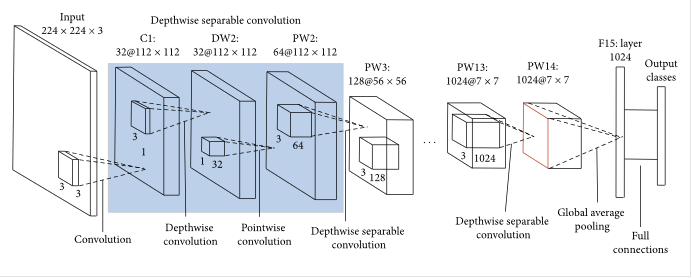

#### (7) [프로그램 코드 및 코드 수준 평가] 소스코드

In [ ]:
# 0. 필수 패키지 설치 및 불러오기
!pip install gdown
!pip install tensorflow
!pip install matplotlib

import gdown
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Google Drive zip 파일 다운로드 및 압축 해제
file_id = "1yaheXiDUbukE-iPZ7UjNdRBI23Y9uX83"
zip_output_path = "/content/ppe_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_output_path, quiet=False)

# 2. 압축 해제
unzip_dir = "/content/ppe_data"
os.makedirs(unzip_dir, exist_ok=True)
with zipfile.ZipFile(zip_output_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# 2-1. 경로 확인
os.listdir("/content/ppe_data/archive")

# 3. 전처리용 ImageDataGenerator 설정
train_dir = "/content/ppe_data/archive/train"
val_dir = "/content/ppe_data/archive/valid"

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 4. 데이터 확인
x, y = next(train_generator)
plt.imshow(x[0])
plt.title(f"Label: {y[0]}")
plt.axis("off")
plt.show()

# 5. 전이학습 모델 구성 (MobileNetV2 + GlobalAveragePooling + Dense)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 학습되지 않도록 고정

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(train_generator.num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# 6. 콜백 설정 및 모델 학습
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    validation_steps=80,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# 7. 학습 결과 시각화(오차 비교)
x_len = np.arange(len(history.history['loss']))
plt.plot(x_len, history.history['val_loss'],marker='.', c="red", markersize=2, label='Val Loss')
plt.plot(x_len, history.history['loss'],marker='.', c="blue", markersize=2, label='Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs. Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# 7-1. 학습 결과 시각화(정확도 비교)
x_len = np.arange(len(history.history['accuracy']))

plt.plot(x_len, history.history['val_accuracy'],marker='.', c="red", markersize=2, label='Val Acc')
plt.plot(x_len, history.history['accuracy'],marker='.', c="blue", markersize=2, label='Train Acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()


#### (8) [단계별 프로그램 수행 보임 및 그 수행 결과 산출 자체에 대한 점수] 도표나 결과 이미지를 통해 산출

In [1]:
# 0. 필수 패키지 설치 및 불러오기
!pip install gdown
!pip install tensorflow
!pip install matplotlib

import gdown
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# 1. Google Drive zip 파일 다운로드 및 압축 해제
file_id = "1B93Q2T2F0U0whih8O27GiihttyFDNJbF"
zip_output_path = "/content/ppe_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1B93Q2T2F0U0whih8O27GiihttyFDNJbF
From (redirected): https://drive.google.com/uc?id=1B93Q2T2F0U0whih8O27GiihttyFDNJbF&confirm=t&uuid=e126403a-7f43-4d29-8694-a7f9385317f6
To: /content/ppe_dataset.zip
100%|██████████| 2.53G/2.53G [00:37<00:00, 67.4MB/s]


'/content/ppe_dataset.zip'

In [3]:
# 2. 압축 해제
unzip_dir = "/content/ppe_data"
os.makedirs(unzip_dir, exist_ok=True)
with zipfile.ZipFile(zip_output_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

In [4]:
# 2-1. 경로 확인
os.listdir("/content/ppe_data/archive")

['data.yaml', 'train', 'test', 'valid']

In [5]:
# 3. 전처리용 ImageDataGenerator 설정
train_dir = "/content/ppe_data/archive/train"
val_dir = "/content/ppe_data/archive/valid"
test_dir = "/content/ppe_data/archive/test"

train_datagen = train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

Found 30765 images belonging to 2 classes.
Found 8813 images belonging to 2 classes.
Found 4423 images belonging to 2 classes.


In [6]:
print(train_generator.class_indices)
print(train_generator.samples)  # 전체 이미지 수
print(train_generator.batch_size)

{'images': 0, 'labels': 1}
30765
128


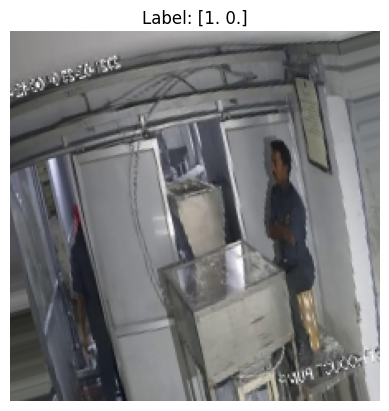

In [7]:
# 4. 데이터 확인
x, y = next(train_generator)
plt.imshow(x[0])
plt.title(f"Label: {y[0]}")
plt.axis("off")
plt.show()

In [8]:
# 5. 전이학습 모델 구성 (MobileNetV2 + GlobalAveragePooling + Dense)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 학습되지 않도록 고정

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(train_generator.num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# 6. 콜백 설정 및 모델 학습
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9983 - loss: 0.0120
Epoch 1: val_loss improved from inf to 0.00008, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.9983 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 7.9567e-05
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 5.5222e-05
Epoch 2: val_loss improved from 0.00008 to 0.00003, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 1.0000 - loss: 5.5186e-05 - val_accuracy: 1.0000 - val_loss: 3.3012e-05
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 2.4051e-05
Epoch 3: val_loss improved from 0.00003 to 0.00002, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 1.0000 - loss: 2.4038e-05 - val_accuracy: 1.0000 - val_loss: 1.7430e-05
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.2472e-05
Epoch 4: val_loss improved from 0.00002 to 0.00001, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 1.0000 - loss: 1.2465e-05 - val_accuracy: 1.0000 - val_loss: 1.0599e-05
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 7.3791e-06
Epoch 5: val_loss improved from 0.00001 to 0.00001, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 1.0000 - loss: 7.3765e-06 - val_accuracy: 1.0000 - val_loss: 7.1691e-06
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 4.8332e-06
Epoch 6: val_loss improved from 0.00001 to 0.00001, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 1.0000 - loss: 4.8311e-06 - val_accuracy: 1.0000 - val_loss: 5.1000e-06
Epoch 7/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 3.5054e-06
Epoch 7: val_loss improved from 0.00001 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 1.0000 - loss: 3.5044e-06 - val_accuracy: 1.0000 - val_loss: 3.7451e-06
Epoch 8/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 2.6464e-06
Epoch 8: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 1.0000 - loss: 2.6449e-06 - val_accuracy: 1.0000 - val_loss: 2.8609e-06
Epoch 9/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.6546e-06
Epoch 9: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 1.0000 - loss: 1.6542e-06 - val_accuracy: 1.0000 - val_loss: 2.2825e-06
Epoch 10/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.3509e-06
Epoch 10: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 1.0000 - loss: 1.3507e-06 - val_accuracy: 1.0000 - val_loss: 1.8234e-06
Epoch 11/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.0080e-06
Epoch 11: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 1.0000 - loss: 1.0077e-06 - val_accuracy: 1.0000 - val_loss: 1.5030e-06
Epoch 12/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 8.5323e-07
Epoch 12: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 1.0000 - loss: 8.5295e-07 - val_accuracy: 1.0000 - val_loss: 1.2476e-06
Epoch 13/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 6.5108e-07
Epoch 13: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 1.0000 - loss: 6.5111e-07 - val_accuracy: 1.0000 - val_loss: 1.0385e-06
Epoch 14/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 6.5459e-07
Epoch 14: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 1.0000 - loss: 6.5425e-07 - val_accuracy: 1.0000 - val_loss: 8.6920e-07
Epoch 15/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 4.5877e-07
Epoch 15: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 1.0000 - loss: 4.5861e-07 - val_accuracy: 1.0000 - val_loss: 7.4145e-07
Epoch 16/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 3.9083e-07
Epoch 16: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 1.0000 - loss: 3.9067e-07 - val_accuracy: 1.0000 - val_loss: 6.3517e-07
Epoch 17/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 2.9004e-07
Epoch 17: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 1.0000 - loss: 2.9007e-07 - val_accuracy: 1.0000 - val_loss: 5.4618e-07
Epoch 18/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 2.1037e-07
Epoch 18: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 1.0000 - loss: 2.1043e-07 - val_accuracy: 1.0000 - val_loss: 4.7799e-07
Epoch 19/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.8984e-07
Epoch 19: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 1.0000 - loss: 1.8988e-07 - val_accuracy: 1.0000 - val_loss: 4.1835e-07
Epoch 20/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.8489e-07
Epoch 20: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 1.0000 - loss: 1.8491e-07 - val_accuracy: 1.0000 - val_loss: 3.6210e-07
Epoch 21/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.9714e-07
Epoch 21: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 1.0000 - loss: 1.9703e-07 - val_accuracy: 1.0000 - val_loss: 3.1338e-07
Epoch 22/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.1261e-07
Epoch 22: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 1.0000 - loss: 1.1263e-07 - val_accuracy: 1.0000 - val_loss: 2.7798e-07
Epoch 23/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.1305e-07
Epoch 23: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 1.0000 - loss: 1.1304e-07 - val_accuracy: 1.0000 - val_loss: 2.4499e-07
Epoch 24/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.0819e-07
Epoch 24: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 1.0000 - loss: 1.0818e-07 - val_accuracy: 1.0000 - val_loss: 2.1386e-07
Epoch 25/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 7.2272e-08
Epoch 25: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 1.0000 - loss: 7.2289e-08 - val_accuracy: 1.0000 - val_loss: 1.9061e-07
Epoch 26/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 8.2318e-08
Epoch 26: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 1.0000 - loss: 8.2300e-08 - val_accuracy: 1.0000 - val_loss: 1.6702e-07
Epoch 27/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 6.3711e-08
Epoch 27: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 1.0000 - loss: 6.3704e-08 - val_accuracy: 1.0000 - val_loss: 1.4907e-07
Epoch 28/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 6.4223e-08
Epoch 28: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 1.0000 - loss: 6.4231e-08 - val_accuracy: 1.0000 - val_loss: 1.2961e-07
Epoch 29/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 5.7928e-08
Epoch 29: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 1.0000 - loss: 5.7945e-08 - val_accuracy: 1.0000 - val_loss: 1.1265e-07
Epoch 30/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 4.2618e-08
Epoch 30: val_loss improved from 0.00000 to 0.00000, saving model to best_model.h5


241/241 ━━━━━━━━━━━━━━━━━━━━ 489s 2s/step - accuracy: 1.0000 - loss: 4.2585e-08 - val_accuracy: 1.0000 - val_loss: 1.0161e-07


In [10]:
# 7. 학습 결과 시각화(정확도)
print("\n Test Accuracy: %.4f" % (model.evaluate(test_generator)[1]))

35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 622ms/step - accuracy: 1.0000 - loss: 4.6180e-08

 Test Accuracy: 1.0000


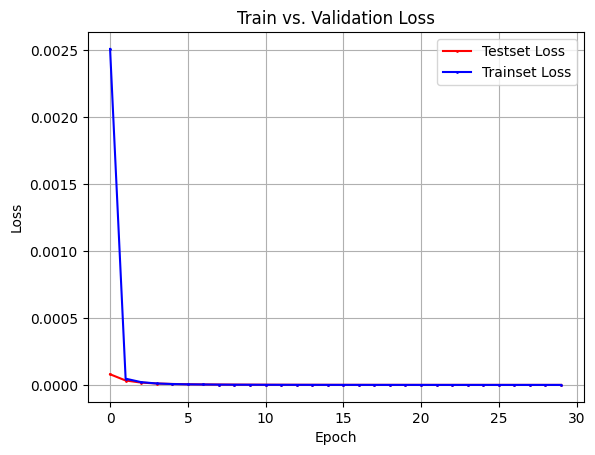

In [11]:
# 7-1. 학습 결과 시각화(오차 비교)

x_len = np.arange(len(history.history['loss']))

plt.plot(x_len, history.history['val_loss'],marker='.', c="red", markersize=2, label='Testset Loss')
plt.plot(x_len, history.history['loss'],marker='.', c="blue", markersize=2, label='Trainset Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs. Validation Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()

#### (9) [설명 및 분석 단계] 제시된 수행 결과 분석 + 결과에 대한 구체적 의미 및 정확도, 수행 과정, 결과 의미 등 설명
> - 학습 및 검증 정확도 결과: 모두 100%,
> - 수행 과정: ImageDataGenerator를 활용해 데이터 증강 및 정규화, MobileNetV2 기반 전이학습 모델 구성 (top layer 제거 + GlobalAveragePooling2D + Dense layer 연결), EarlyStopping과 ModelCheckpoint를 통해 최적 성능 시점에서 학습 중단 및 가중치 저장,
> - 결과의 의미: 데이터의 수가 많음에도 불구하고 정확도 100%에 수렴했다는 것은 전처리한 데이터의 클래스 간 구분이 매우 뚜렷하고 쉬운 경우로 볼 수 있을 것 같다.

#### (10) 생성한 모델의 기대 효과:
> 초기 모델 보다 훨씬 발전 시킨다면, 산업현장의 CCTV 영상을 분석하여 현장 작업자의 PPE 착용 여부를 실시간으로 감지할 수 있을 것이다. 이를 통해 관리자가 더 쉽게 안전 상태를 점검할 수 있어, 인력 부족 상황에서도 효율적인 안전관리가 가능하다. 헬멧이나 조끼 미착용 상태를 조기에 발견함으로써, 산업재해를 사전에 예방할 수 있을 것으로 기대한다. 실제 사고 발생 전에 경고를 줄 수 있어, 현장 작업자의 생명과 안전을 보호하는 데 큰 도움이 된다. 또한 모델 경량화를 통해 추후 모바일 기기 및 디바이스에 이식하여 보다 실시간적이고 유연하게 사용할 수 있을 것으로 기대한다.

#### (11) 도움을 받은 소스 (친구명, 인터넷 링크명, LLM의 질문 내용, 도움 받은 정도가 과제에 미친 정도 % 명기)
> - 강의록 [2025 Data Pattern Recognition] 07. Making a model using Real Data  (과제에 미친 정도: 40%)
> - gdown 라이브러리 https://github.com/wkentaro/gdown (과제에 미친 정도: 10%)
> - zipfile 모듈 https://docs.python.org/3/library/zipfile.html (과제에 미친 정도: 10%)
> - 그 외 강의록에 있는 수많은 코드들 (5%)

#### (12) 상기 과제에 투자한 총 시간: ( 13 ) 시간, 아래 구체적 명기
> - ①. 주제 선정 시간: 1시간
> - ②. 모델 설계 시간: 2시간
> - ③. 데이터 제작 및 수급 관련 시간: 1시간
> - ④. (딥러닝) 프로그래밍 시간: 3시간
> - ⑤. (딥러닝) 학습 시간: 3시간
> - ⑥. 오류 해결 등을 위한 자문 시간 및 자문 대상(사람, 정보) 기술: 정보(도움 받은 소스 참고)
> - ⑦. 자체 결과 분석 시간: 1시간
> - ⑧. 결과 보고서 작성 시간: 1시간
> - ⑨. 최종검토 시간: 1시간

#### (13) 본 프로젝트 수행을 성장한 부분:
> 이번 과제를 통해 CNN(Convolutional Neural Network)의 기본 구조와 작동 원리를 구체적으로 이해할 수 있었다. 특히 사전학습된 모델을 기반으로 새로운 데이터셋에 맞게 학습을 이어가는 전이학습(Transfer Learning)의 개념과 적용 방법을 실습할 수 있었다. 데이터를 학습에 적합한 형태로 전처리하는 과정을 직접 수행해 보며 데이터 전처리 과정의 중요성을 알게 되었다. 또한 디렉토리 구조 설계, Colab-Drive 연동 등을 경험할 수 있었다. 대규모 이미지 데이터셋을 실제로 다루어 보았다. 또한 데이터 간의 구분이 쉬워 모델이 패턴을 빠르게 학습해 정확도가 높게 나올 수도 있다는 것을 알게 되었다. 모델 성능을 수치뿐만 아니라 시각화하는 방법도 익혔다. 이러한 일련의 과정을 통해 이론과 실습을 연결하는 통합적인 프로젝트 수행 역량을 키울 수 있었다.

#### (14) 과제 수행 과정과 결과를 통해, 본인이 요청하는 정직한 점수 및 그 사유:
> - 점수: 10/10
> - 사유: 본인은 본 과제에서 산업현장 내 안전사고 예방을 위한 PPE 객체 인식 모델 구축을 목표로, 약 4만 장에 달하는 이미지 데이터를 활용한 전이학습 기반 딥러닝 모델을 구성하였다. 사용된 데이터셋은 Kaggle에서 공개된 YOLOv8 포맷 PPE 이미지 데이터를 활용하였으며, 이를 Google Drive에 직접 연결하고, Colab에서 전처리 및 모델 학습을 구현하였다. MobileNetV2을 기반으로 하는 CNN 전이학습 모델을 구성하였고, ImageDataGenerator, ModelCheckpoint, EarlyStopping 등의 기법을 적절히 활용하여 모델 성능을 안정화 하였다. 특히 데이터셋 크기에 따른 학습 시간 이슈를 해결하기 위해 epoch, batch_size, early_stopping 등의 최적화를 스스로 적용하여 모델을 학습시켜 보았다.
과제 수행 전반에 걸쳐 모델 구성, 학습, 성능 평가 및 시각화, 보고서 작성까지 모든 과정을 스스로 진행하였다. 과제 주제 선정, 모델 구성, 데이터 연계, 시각화 및 성능 분석, 최종 보고서까지 모두 수행하였으므로, 본인은 창의성, 난이도, 기술 완성도 측면에서 10.0점 만점을 요청함.